In [19]:
import numpy as np
def map_clip(old,coup,bias,a,b,noi):   #linear map with clipping
    return np.clip(a*old+b*np.dot(coup,old)+.40*b*bias+np.random.normal(0,noi,len(old)),-.4,.4)
def map_cos(old,coup,bias,a,b,noi):   #linear map with clipping
    return np.clip(a*old+b*np.dot(coup,old)+.40*b*bias+np.random.normal(0,noi,len(old)),-.4,.4)
def map_pol(old,coup,bias,a,b,noi):   #linear map with clipping
    return np.clip((a)*old-old**3+b*np.dot(coup,old)+np.abs(np.max(old))*b*bias+np.random.normal(0,noi,len(old)),-10,10)
def map_tanh(old,coup,bias,a,b,noi):   #linear map with clipping
    return np.tanh(a*old+b*np.dot(coup,old)+np.abs(np.max(old))*b*bias+np.random.normal(0,noi,len(old)))
def ising_energy(stuff,ad,bias):
    return -0.5*1*np.dot(stuff,np.dot(ad,stuff))-np.sum(np.dot(bias,stuff))
def ising_sample(NN,n_hid):   
    global result
    global ens2
    global ad
    global chain
    global bias
    test=np.loadtxt(r'bla.txt') #edge list
    N=int(np.max(test)) #number of nodes
    #negat=np.abs(np.identity(N)-1)
    ad=np.zeros((N,N)) #adjacency matrix
    for i in range(0,len(test)): #initialize
        ad[int(test[i,0])-1,int(test[i,1])-1]+=(test[i,2])
    bias=np.zeros(N)
    for i in range(0,N):
        bias[i]+=ad[i,i]
        ad[i,i]=0
    # parameters for alpha and beta
    a=0.9
    b=0.1
    noise_strength=0.12
    chain=np.zeros(N)
    ens2=np.zeros(NN)
    result=np.zeros((NN,N))
    for i in range(0,NN):
        chain=map_clip(chain,ad,bias,a,b,noise_strength)   #calls Euler integration step, chose the map_xxx function to select different nonlinearities
        result[i,:]=chain
        ens2[i]=ising_energy(chain,ad,bias)
            
    return [0.5*(np.sign(result[:,:n_hid])+1),0.5*(np.sign(result[:,n_hid:])+1)]

In [20]:
"""Restricted Boltzmann Machine
"""
import time

import numpy as np
import scipy.sparse as sp
from scipy.special import expit  # logistic function
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.utils import check_array
from sklearn.utils import check_random_state
from sklearn.utils import gen_even_slices
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.extmath import log_logistic
from sklearn.utils.validation import check_is_fitted, _deprecate_positional_args
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets, metrics
class BernoulliRBM(TransformerMixin, BaseEstimator):
    def __init__(self, n_components=256, *, learning_rate=0.1, batch_size=100,
                 n_iter=30, verbose=0, random_state=None):
        self.n_components = n_components
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_iter = n_iter
        self.verbose = verbose
        self.random_state = random_state

    def transform(self, X):
        """Compute the hidden layer activation probabilities, P(h=1|v=X).

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            The data to be transformed.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Latent representations of the data.
        """
        check_is_fitted(self)

        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        return self._mean_hiddens(X)

    def _mean_hiddens(self, v):
        """Computes the probabilities P(h=1|v).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Corresponding mean field values for the hidden layer.
        """
        p = safe_sparse_dot(v, self.components_.T)
        p += self.intercept_hidden_
        return expit(p, out=p)

    def _sample_hiddens(self, v, rng):
        """Sample from the distribution P(h|v).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer to sample from.

        rng : RandomState
            Random number generator to use.

        Returns
        -------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer.
        """
        p = self._mean_hiddens(v)
        return (rng.random_sample(size=p.shape) < p)

    def _sample_visibles(self, h, rng):
        """Sample from the distribution P(v|h).

        Parameters
        ----------
        h : ndarray of shape (n_samples, n_components)
            Values of the hidden layer to sample from.

        rng : RandomState
            Random number generator to use.

        Returns
        -------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.
        """
        p = np.dot(h, self.components_)
        p += self.intercept_visible_
        expit(p, out=p)
        return (rng.random_sample(size=p.shape) < p)

    def _free_energy(self, v):
        """Computes the free energy F(v) = - log sum_h exp(-E(v,h)).

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer.

        Returns
        -------
        free_energy : ndarray of shape (n_samples,)
            The value of the free energy.
        """
        return (- safe_sparse_dot(v, self.intercept_visible_)
                - np.logaddexp(0, safe_sparse_dot(v, self.components_.T)
                               + self.intercept_hidden_).sum(axis=1))

    def gibbs(self, v):
        """Perform one Gibbs sampling step.

        Parameters
        ----------
        v : ndarray of shape (n_samples, n_features)
            Values of the visible layer to start from.

        Returns
        -------
        v_new : ndarray of shape (n_samples, n_features)
            Values of the visible layer after one Gibbs step.
        """
        check_is_fitted(self)
        if not hasattr(self, "random_state_"):
            self.random_state_ = check_random_state(self.random_state)
        h_ = self._sample_hiddens(v, self.random_state_)
        v_ = self._sample_visibles(h_, self.random_state_)

        return v_

    def partial_fit(self, X, y=None):
        """Fit the model to the data X which should contain a partial
        segment of the data.

        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            Training data.

        Returns
        -------
        self : BernoulliRBM
            The fitted model.
        """
        X = check_array(X, accept_sparse='csr', dtype=np.float64)
        if not hasattr(self, 'random_state_'):
            self.random_state_ = check_random_state(self.random_state)
        if not hasattr(self, 'components_'):
            self.components_ = np.asarray(
                self.random_state_.normal(
                    0,
                    0.01,
                    (self.n_components, X.shape[1])
                ),
                order='F')
        if not hasattr(self, 'intercept_hidden_'):
            self.intercept_hidden_ = np.zeros(self.n_components, )
        if not hasattr(self, 'intercept_visible_'):
            self.intercept_visible_ = np.zeros(X.shape[1], )
        if not hasattr(self, 'h_samples_'):
            self.h_samples_ = np.zeros((self.batch_size, self.n_components))

        self._fit(X, self.random_state_)

    def _fit(self, v_pos, rng):
        """Inner fit for one mini-batch.

        Adjust the parameters to maximize the likelihood of v using
        Stochastic Maximum Likelihood (SML).

        Parameters
        ----------
        v_pos : ndarray of shape (n_samples, n_features)
            The data to use for training.

        rng : RandomState
            Random number generator to use for sampling.
        """
        h_pos = self._mean_hiddens(v_pos)
        self.make_jij()

        #uncomment line below for CIM Sampling
        h_neg,v_neg=ising_sample(1000,len(self.components_))
        #uncomment line below for Metropolis Sampling
        #h_neg,v_neg=mcmc_sample(10000,len(self.components_))
        #uncomment line below for Gibbs sampling
        #v_neg = self._sample_visibles(self.h_samples_, rng)
        #h_neg = self._mean_hiddens(v_neg)
        
        lengg=(len(h_neg))

        lr = float(self.learning_rate) / v_pos.shape[0]
        update = safe_sparse_dot(v_pos.T, h_pos, dense_output=True).T
        update -= np.dot(h_neg.T, v_neg)/(lengg/self.batch_size)
        self.components_ += lr * update
        self.intercept_hidden_ += lr * (h_pos.sum(axis=0) - h_neg.sum(axis=0)/(lengg/self.batch_size))
        self.intercept_visible_ += lr * (np.asarray(
                                         v_pos.sum(axis=0)).squeeze() -
                                         v_neg.sum(axis=0)/(lengg/self.batch_size))

        h_neg[rng.uniform(size=h_neg.shape) < h_neg] = 1.0  # sample binomial
        self.h_samples_ = np.floor(h_neg, h_neg)

    def score_samples(self, X):
        """Compute the pseudo-likelihood of X.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Values of the visible layer. Must be all-boolean (not checked).

        Returns
        -------
        pseudo_likelihood : ndarray of shape (n_samples,)
            Value of the pseudo-likelihood (proxy for likelihood).

        Notes
        -----
        This method is not deterministic: it computes a quantity called the
        free energy on X, then on a randomly corrupted version of X, and
        returns the log of the logistic function of the difference.
        """
        check_is_fitted(self)

        v = check_array(X, accept_sparse='csr')
        rng = check_random_state(self.random_state)

        # Randomly corrupt one feature in each sample in v.
        ind = (np.arange(v.shape[0]),
               rng.randint(0, v.shape[1], v.shape[0]))
        if sp.issparse(v):
            data = -2 * v[ind] + 1
            v_ = v + sp.csr_matrix((data.A.ravel(), ind), shape=v.shape)
        else:
            v_ = v.copy()
            v_[ind] = 1 - v_[ind]

        fe = self._free_energy(v)
        fe_ = self._free_energy(v_)
        return v.shape[1] * log_logistic(fe_ - fe)
    
    def make_jij(self):
        temp=np.zeros(0)
        #print(self.components_)
        n_hidd=len(self.components_)
        n_vis=len(self.components_[0])
        for i in range(0,n_hidd):
                        
            for j in range(0,n_vis):
                if(self.components_[i,j]!=0):
                    temp=np.append(temp,[(i+1),(j+1+n_hidd),0.25*(self.components_[i,j])])
                    temp=np.append(temp,[(j+1+n_hidd),(i+1),0.25*(self.components_[i,j])])
                   
        for i in range(0,n_hidd):
            temp2=0
            for j in range(0,n_vis):
                temp2+=self.components_[i,j]
            temp=np.append(temp,[i+1,i+1,(0.5*self.intercept_hidden_[i]+0.25*temp2)])
            
        for i in range(0,n_vis):
            temp2=0
            for j in range(0,n_hidd):
                temp2+=self.components_[j,i]
            temp=np.append(temp,[n_hidd+i+1,n_hidd+i+1,(0.5*self.intercept_visible_[i]+0.25*temp2)])
        
        temp=temp.reshape(2*n_hidd*n_vis+n_hidd+n_vis,3)
        np.savetxt(r'bla.txt',temp,delimiter=' ',newline='\n',fmt='%.10f')
        
    
    def fit(self, X, Y_train, X_test, Y_test):
        """Fit the model to the data X.

        Parameters
        ----------
        X : {array-like, sparse matrix} of shape (n_samples, n_features)
            Training data.

        Returns
        -------
        self : BernoulliRBM
            The fitted model.
        """
        logistic = linear_model.LogisticRegression(solver='newton-cg', tol=1)
        logistic.C = 6000.0
        X = self._validate_data(X, accept_sparse='csr', dtype=np.float64)
        n_samples = X.shape[0]
        rng = check_random_state(self.random_state)
        
        self.batch_size=100
        likelhd=np.zeros(2161)
        predic=np.zeros(2161)
        self.components_ = np.asarray(
            rng.normal(0, 0.01, (self.n_components, X.shape[1])),
            order='F')
        self.intercept_hidden_ = np.zeros(self.n_components, )
        self.intercept_visible_ = np.zeros(X.shape[1], )
        self.h_samples_ = np.zeros((self.batch_size, self.n_components))

        n_batches = int(np.ceil(float(n_samples) / self.batch_size)) #7188/100 71
        batch_slices = list(gen_even_slices(n_batches * self.batch_size,
                                            n_batches, n_samples=n_samples))
        verbose = self.verbose
        begin = time.time()
        numnum=0 #n_batch * self.n_iter
        likelhd=[]
        predic=[]
        for iteration in range(1, self.n_iter + 1):
            for batch_slice in batch_slices:
                numnum+=1
                self._fit(X[batch_slice], rng)
                if verbose:
                    end = time.time()
                    # likelhd[numnum-1]=self.score_samples(X).mean()
                    likelhd.append(self.score_samples(X).mean())
                    # predic[numnum]=logistic.fit((self._mean_hiddens(X)), Y_train).score((self._mean_hiddens(X_test)), Y_test)
                    print("[%s] Iteration %d, pseudo-likelihood = %.2f," " time = %.2fs" % (type(self).__name__, numnum, self.score_samples(X).mean(), end - begin))
                    begin = end
                    # predic[numnum]=logistic.fit((self._mean_hiddens(X)), Y_train).score((self._mean_hiddens(X_test)), Y_test)
                    # 初始化随机森林分类器
                    rf = RandomForestClassifier()
                    predic.append(rf.fit((self._mean_hiddens(X)), Y_train).score((self._mean_hiddens(X_test)), Y_test))
                    print(predic[numnum-1])
                    if (numnum-1)%20==0:
                        xx = X[:40].copy()
                        for ii in range(1000):
                            for n in range(40):
                                xx[n]=rbm.gibbs(xx[n])
                        plt.figure(figsize=(16,2))
                        plt.imshow(gen_minst_image(xx))
                        plt.show()
        #print(self.make_jij())
        plt.xlabel('Training iteration')  # X轴标签
        plt.ylabel('Pseudolikelihood ')  # Y轴标签
        plt.plot(likelhd)
        plt.show()
        plt.plot(predic)
        plt.xlabel('Training iteration')  # X轴标签
        plt.ylabel('Prediction accuracy')  # Y轴标签
        plt.show()
        np.savetxt('out_likelhd.txt',likelhd)
        np.savetxt('out_pred.txt',predic)
        return self

    def _more_tags(self):
        return {
            '_xfail_checks': {
                'check_methods_subset_invariance':
                'fails for the decision_function method'
            }
        }

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap']='gray'
def gen_minst_image(X):
    return np.rollaxis(np.rollaxis(X[0:200].reshape(20,-1,8,8),0,2),1,3).reshape(-1,20*8)

(7188, 64)


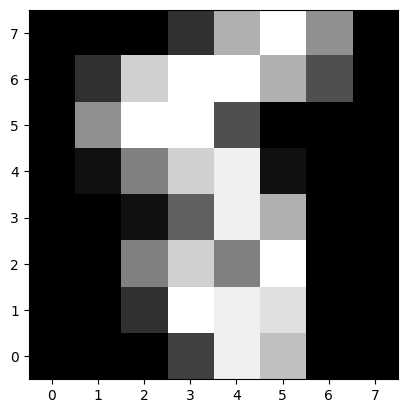

In [22]:
from sklearn.datasets import load_digits
import numpy as np
from scipy.ndimage import shift
from sklearn.model_selection import train_test_split
# 加载手写数字数据集
digits = load_digits()

# 获取图像数据和标签
images = digits.images  # 8x8 的图像矩阵
plt.imshow(images[2], origin='lower',cmap="gray")
labels = digits.target  # 对应的标签
##新的数据集
# 定义平移函数
def translate_image(image, direction):
    if direction == 'up':
        return shift(image, [-1, 0], mode='constant', cval=0)
    elif direction == 'down':
        return shift(image, [1, 0], mode='constant', cval=0)
    elif direction == 'left':
        return shift(image, [0, -1], mode='constant', cval=0)
    elif direction == 'right':
        return shift(image, [0, 1], mode='constant', cval=0)
    else:
        raise ValueError("Invalid direction. Use 'up', 'down', 'left', or 'right'.")
# 扩展数据集
expanded_images = []
expanded_labels = []
for image, label in zip(images, labels):
    # 原始图像
    expanded_images.append(image)
    expanded_labels.append(label)
    # 向四个方向平移
    for direction in ['up', 'down', 'left', 'right']:
        translated_image = translate_image(image, direction)
        expanded_images.append(translated_image)
        expanded_labels.append(label)
        # 将列表转换为 NumPy 数组
expanded_images= np.array(expanded_images)
expanded_labels= np.array(expanded_labels)
# 将图像数据展平为二维数组 (n_samples, 64)
n_samples = expanded_images.shape[0]
data = expanded_images.reshape((n_samples, -1))

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(data, expanded_labels, test_size=0.2, random_state=42)
X_train=(X_train-np.min(X_train,0))/(np.max(X_train,0)+0.0001)
X_test=(X_test-np.min(X_test,0))/(np.max(X_test,0)+0.0001)
print(X_train.shape)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -33.84, time = 0.21s
0.9254312743461325


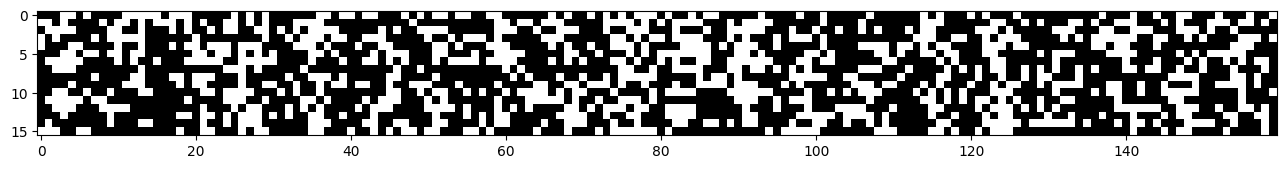

[BernoulliRBM] Iteration 2, pseudo-likelihood = -31.73, time = 4.47s
0.905954368391764
[BernoulliRBM] Iteration 3, pseudo-likelihood = -30.68, time = 3.97s
0.8948247078464107
[BernoulliRBM] Iteration 4, pseudo-likelihood = -30.25, time = 4.63s
0.8820255982192543
[BernoulliRBM] Iteration 5, pseudo-likelihood = -30.09, time = 4.38s
0.89259877573734
[BernoulliRBM] Iteration 6, pseudo-likelihood = -29.77, time = 4.49s
0.8853644963828603
[BernoulliRBM] Iteration 7, pseudo-likelihood = -29.57, time = 5.18s
0.8898163606010017
[BernoulliRBM] Iteration 8, pseudo-likelihood = -29.43, time = 4.61s
0.8931552587646077
[BernoulliRBM] Iteration 9, pseudo-likelihood = -29.36, time = 4.76s
0.8764607679465777
[BernoulliRBM] Iteration 10, pseudo-likelihood = -29.34, time = 4.14s
0.8820255982192543
[BernoulliRBM] Iteration 11, pseudo-likelihood = -29.29, time = 4.03s


KeyboardInterrupt: 

In [23]:
rbm = BernoulliRBM(n_components=100, learning_rate=0.1, random_state=0, verbose=True)
rbm.fit(X_train,y_train,X_test,y_test)


Test Set Performance:
Accuracy: 0.9694

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.93      1.00      0.97        28
           2       1.00      0.97      0.98        33
           3       1.00      0.94      0.97        34
           4       1.00      0.96      0.98        46
           5       0.98      0.98      0.98        47
           6       0.97      0.94      0.96        35
           7       0.92      0.97      0.94        34
           8       0.91      1.00      0.95        30
           9       0.97      0.95      0.96        40

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



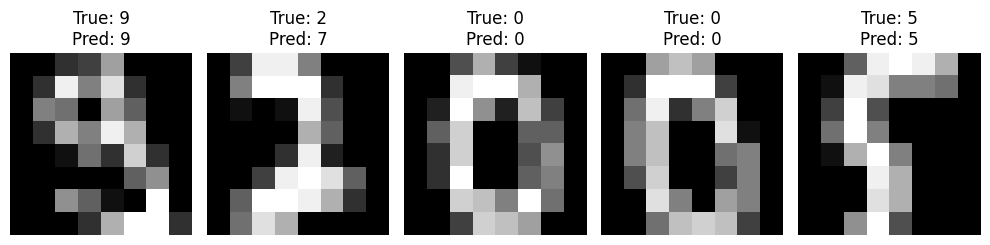

In [17]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier  # 使用梯度提升分类器
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits  # 加载手写数字数据集
import matplotlib.pyplot as plt

# 训练梯度提升模型
def train_gradient_boosting(X_train, y_train):
    # 创建梯度提升模型
    model = GradientBoostingClassifier(
        n_estimators=100,  # 树的数量
        learning_rate=0.1,  # 学习率
        max_depth=3,  # 每棵树的最大深度
        random_state=42
    )
    # 训练模型
    model.fit(X_train, y_train)
    
    return model

# 预测并评估模型性能
def evaluate_model(model, X_test, y_test):
    # 在测试集上进行预测
    y_pred = model.predict(X_test)
    # 计算准确率
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    # 打印分类报告
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# 可视化部分预测结果
def visualize_predictions(model, X_test, y_test, n_samples=5):
    # 获取预测结果
    y_pred = model.predict(X_test)
    
    # 随机选择 n_samples 个样本进行可视化
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    plt.figure(figsize=(10, 6))
    for i, idx in enumerate(indices, start=1):
        plt.subplot(1, n_samples, i)
        img = X_test[idx].reshape(8, 8)  # 假设数据为 8x8 图像
        plt.imshow(img, cmap='gray')
        plt.title(f'True: {y_test[idx]}\nPred: {y_pred[idx]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":

    # 训练梯度提升模型
    model = train_gradient_boosting(X_train, y_train)
    
    # 在测试集上评估模型
    print("\nTest Set Performance:")
    evaluate_model(model, X_test, y_test)
    
    # 可视化部分预测结果
    visualize_predictions(model, X_test, y_test)